In [ ]:
!pip install numpy==1.24.4 scipy==1.13.1 --force-reinstall

In [ ]:
import nltk

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 89.2 MB/s eta 0:00:00


In [ ]:
import gensim

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 83.7 MB/s eta 0:00:00


In [ ]:
import gensim

In [ ]:
import numpy as np
import pandas as pd
import re
import json
import sys
import os
import ast
import random
import nltk

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import re
import json
import sys
import os
import ast
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud, ImageColorGenerator

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/aai-510/assignment/assignment-5/assignment_5_data'

Mounted at /content/drive


In [ ]:
# Load the datasets
root_location = '/content/drive/My Drive/Colab Notebooks/aai-510/assignment/assignment-5/assignment_5_data'


file_locations = [f'{root_location}/biorxiv_medrxiv/biorxiv_medrxiv',
                  f'{root_location}/noncomm_use_subset/noncomm_use_subset',
                  f'{root_location}/comm_use_subset/comm_use_subset',
                  f'{root_location}/custom_license/custom_license']

In [ ]:
print(file_locations)

['/content/drive/My Drive/Colab Notebooks/aai-510/assignment/assignment-5/assignment_5_data/biorxiv_medrxiv/biorxiv_medrxiv', '/content/drive/My Drive/Colab Notebooks/aai-510/assignment/assignment-5/assignment_5_data/noncomm_use_subset/noncomm_use_subset', '/content/drive/My Drive/Colab Notebooks/aai-510/assignment/assignment-5/assignment_5_data/comm_use_subset/comm_use_subset', '/content/drive/My Drive/Colab Notebooks/aai-510/assignment/assignment-5/assignment_5_data/custom_license/custom_license']


In [ ]:
import numpy as np
import pandas as pd
import re
import json
import sys
import os
import ast
import random
import nltk

import wordcloud
#import faiss
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

class process_articles:

    def __init__(self, file_locs, stopwords):

        self.file_locs = file_locs
        self.stopwords = stopwords

    def read_files(self):

        self.title_text = []

        for file_loc in self.file_locs:

            ## Get all files from specified location
            print('Processing Files at the requested location')
            #print(file_loc)
            self.raw_root_files = os.listdir(file_loc)

            # Randomly sample files to reduce training file size - 10% of files from each supply
            self.root_files = []
            for val in np.arange(int(len(self.raw_root_files) / 5)):

                self.root_files.append(random.choice(self.raw_root_files))

            print('There are {} files to process'.format(len(self.root_files)))
            print('There were {} files in the dataset'.format(len(self.raw_root_files)))
            file_root = file_loc.split('/')[1]

            ## Loop through each file and grab the title and text

            for file in self.root_files:

                with open('{}/{}'.format(file_loc, file)) as f:
                    art_text_fin = []

                    try:
                        ## Load article and extract title
                        article = json.load(f)
                        art_title = article['metadata']['title']

                        ## Text is stored in multiple blocks - loop through each one
                        art = article['body_text']
                        art_text = []
                        for text in np.arange(len(art)):
                            raw_text = art[text]['text']
                            art_text.append(raw_text)

                        ## Condense each block together in a single form
                        ## Store raw text and titles in list
                        art_text_fin.append(" ".join(str(text_block) for text_block in art_text))
                        self.title_text.append([file_root, art_title, art_text_fin])

                    except:

                        print('FAILURE !!! \n')
                        print(article)

    def process_text(self):

        p_stemmer = PorterStemmer()
        articles = [article[2] for article in self.title_text]

        ## Process Each document - remove junk

        print('Cleaning out Junk')

        articles = [str(article).lower() for article in articles]
        articles = [re.sub('<[^<]+?>', '', article) for article in articles]
        articles = [re.sub(r'http\S+', '', article) for article in articles]
        articles = [re.sub(r'[^A-Za-z0-9]+', ' ', article) for article in articles]
        articles = [re.sub(r'\\', '', article) for article in articles]
        articles = [re.sub(r'\[.*?\]', '', article) for article in articles]
        articles = [re.sub(r'\d+', '', article) for article in articles]

        ## Tokenize
        ## deacc=True drops out punctuation

        print('Tokenizing words')

        articles = [gensim.utils.simple_preprocess(str(article), deacc=True) for article in articles]
        articles = [ast.literal_eval(str(article)) for article in articles]

        ## Convert into words
        ## Clean out stop words

        print('Converting to list of words and removing stop words')

        articles = [[word.strip() for word in article] for article in articles]
        articles = [[word for word in article if word not in self.stopwords] for article in articles]

        ## Stem words

        print('Creating word stems')

        articles = [[p_stemmer.stem(word) for word in article] for article in articles]

        self.processed_article = [[tt[0], tt[1], tt[2], article] for tt, article in zip(self.title_text, articles)]

    def bigrams(self, tokenized_articles, min_count=3, threshold=30):

        ## Create bigrams from raw tokenized text provided

        bigram = gensim.models.Phrases(tokenized_articles, min_count = min_count, threshold = threshold)
        bigram_mod = gensim.models.phrases.Phraser(bigram)
        bigram_fin = [bigram_mod[article] for article in tokenized_articles]

        self.bigram = bigram_fin

    def trigrams(self, tokenized_articles, min_count=3, threshold=30):

        print('Creating Bigrams')

        ## Create bigrams from raw tokenized text provided

        bigram = gensim.models.Phrases(tokenized_articles, min_count = min_count, threshold = threshold)
        bigram_mod = gensim.models.phrases.Phraser(bigram)

        print('Creating Trigrams from Bigrams')

        ## Create trigrams from the bigram model and raw text

        trigram = gensim.models.Phrases(bigram[tokenized_articles])
        trigram_mod = gensim.models.phrases.Phraser(trigram)
        trigram_fin = [trigram_mod[bigram_mod[article]] for article in tokenized_articles]
        trigram_fin = [str(trigram) for trigram in trigram_fin]

        self.processed_trigrams = [[pa[0], pa[1], pa[2], pa[3], trigram] for pa, trigram in zip(self.processed_article, trigram_fin)]

def train_test_splitter(processed_text, train_prop):

    train = processed_text[0:int(len(processed_text) * train_prop)]
    test = processed_text[int(len(processed_text) * 0.8):]

    return train, test

class LDA_Evaluator:

    def __init__(self, lda_model, vectorizer):

        self.lda_model = lda_model
        self.feature_names = vectorizer.get_feature_names_out()
        self.vectorizer = vectorizer

        ## Create DF

        components = pd.DataFrame(self.lda_model.components_).copy()
        components['fullsum'] = components.sum(axis=1)

        self.components = components

        ## Determine Component Contribution

        allwords = self.components['fullsum'].sum()
        self.topic_distro = self.components['fullsum'] / allwords

        for col in self.components.columns:
            self.components[col] = self.components[col] / self.components['fullsum']
        self.components.drop(['fullsum'], inplace = True, axis = 1)
        self.components = self.components.transpose()
        self.components['wordmean'] = self.components.mean(axis=1)
        self.components.index = self.feature_names

        ## Determine Word Distribution

        words = pd.DataFrame(self.lda_model.components_).copy()
        words = words.transpose()
        words['fullsum'] = words.sum(axis=1)
        wordstotal = words['fullsum'].sum()
        word_distribution = words['fullsum'] / wordstotal
        word_rank = word_distribution.rank() / len(word_distribution)

        ## Add back to DF

        self.components['word_rank'] = word_rank.values
        self.components['word_distro'] = word_distribution.values

    def eval_raw_frequency(self, topic, num_words, threshold=0):

        ## Returns words that show up most per topic

        raw_vals = self.components.copy()
        raw_vals = raw_vals[raw_vals['word_rank'] >= threshold]

        return raw_vals.sort_values(by=topic, ascending=False).head(n=num_words)

    def eval_rel_frequency(self, topic, num_words, threshold = 0):

        ## Returns words that show up disproportionately by topic

        rel_freq = self.components.copy()
        rel_freq = rel_freq[rel_freq['word_rank'] >= threshold]
        for col in rel_freq[0:(len(rel_freq.columns)-1)]:
            rel_freq[col] = rel_freq[col] / rel_freq['wordmean'] ## Calc how much higher/lower prop is

        return rel_freq.sort_values(by=topic, ascending = False).head(n=num_words)

class wcEval:

    def __init__(self, data, vectorizer, ldamod):

        self.term_freq = vectorizer.transform([t[4] for t in data])
        self.topic_scores = pd.DataFrame(ldamod.transform(self.term_freq))
        self.topic_cols = self.topic_scores.columns.values

    def raw_freq_wc(self):

        test_topics = self.topic_scores.copy()

        test_topics['max'] = test_topics.max(axis=1)
        test_topics['max_topic_num'] = 99
        for col in self.topic_cols:
            test_topics['max_topic_num'] = np.where(test_topics['max'] == test_topics[col], col, test_topics['max_topic_num'])

        primary_topic = test_topics['max_topic_num'].tolist()

        self.raw_primary_topic = primary_topic

    def rel_freq_wc(self):

        test_topics = self.topic_scores.copy()

        ## Convert to relative freq

        for col in self.topic_cols:
            test_topics[col] = test_topics[col] / np.mean(test_topics[col])

        ## Find max per column

        test_topics['max'] = test_topics.max(axis=1)
        test_topics['max_topic_num'] = 99

        for col in self.topic_cols:
            test_topics['max_topic_num'] = np.where(test_topics['max'] == test_topics[col], col, test_topics['max_topic_num'])

        primary_topic = test_topics['max_topic_num'].tolist()

        self.rel_primary_topic = primary_topic

def word_clouds(data, topic, max_words, stop_words, evalinfo):

    word_cloud = [str(t[1]) for t in data if t[2] == topic]
    print(f'Percentage in topic {topic}: {np.around(len(word_cloud) / len(data), 4)}')
    word_cloud = ' '.join(w for w in word_cloud)

    wordcloud = WordCloud(max_words = max_words, stopwords = stop_words).generate(word_cloud)

    #plt.set_size_inches(18.5, 10.5)
    plt.figure( figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print(f'10 highest relative frequency words in topic {topic}:\n')
    print(evalinfo.eval_rel_frequency(topic, 10).index.values)
    print('\n')

In [ ]:
import ast
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

# Create an instance of the process_articles class
processor = process_articles(file_locations, stopwords.words('english'))

# Call the read_files method to initialize title_text
processor.read_files()

# Call the process_text method on the instance
processor.process_text()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Processing Files at the requested location
There are 179 files to process
There were 895 files in the dataset
Processing Files at the requested location
There are 486 files to process
There were 2431 files in the dataset
Processing Files at the requested location
There are 1839 files to process
There were 9197 files in the dataset
Processing Files at the requested location
There are 3397 files to process
There were 16989 files in the dataset
Cleaning out Junk
Tokenizing words
Converting to list of words and removing stop words
Creating word stems


In [ ]:
import wordcloud
#import faiss
from nltk.corpus import stopwords

In [ ]:
stop_words = stopwords.words('english') + ['et', 'al', 'fig', 'etal', 'et al', 'et-al']

processed_articles = process_articles(file_locations, stop_words)
processed_articles.read_files()

print('Example File Name----------> ')
print(processed_articles.root_files[0])
print('Number of files------------>')
print(len(processed_articles.root_files))
print('Example Article Information----------->')
print(processed_articles.title_text[2])

Processing Files at the requested location
There are 179 files to process
There were 895 files in the dataset
Processing Files at the requested location
There are 486 files to process
There were 2431 files in the dataset
Processing Files at the requested location
There are 1839 files to process
There were 9197 files in the dataset
Processing Files at the requested location
There are 3397 files to process
There were 16989 files in the dataset
Example File Name----------> 
9d55e06359a9e4879f7a19d846ffbca8fc8e8768.json
Number of files------------>
3397
Example Article Information----------->
['content', 'Understanding the present status and forecasting of COVID-19 in Wuhan', ['Pneumonia originated in Wuhan, which is referred as COVID-19 in the following, is now a great fear in the world. The fear of people is caused by no existence of forecasting of the final scale of the disaster and the end of the disease. This paper reports forecasting of the end of the COVID-19 epidemic. As a result o

## LDA with 10 Topics

###Topic 1: Calcium Ions and Viral Entry

###Top Words: calcium, fusion, membrane, entry, concentration

Summary: This topic focuses on how Ca2 ions regulate membrane fusion and viral infectivity, especially in the context of coronavirus spike protein interactions.

Why it stands out: Strong emphasis on biophysics and ion dependence of viral mechanisms.

###Topic 2: Mutations and Protein Expression

###Top Words: mutation, spike, alanine, expression, residue

Summary: Discusses mutagenesis experiments, especially amino acid substitutions in spike protein regions.

Why it stands out: Focused on site-directed mutagenesis and functional outcomes.

###Topic 3: Infectivity and Viral Assays

###Top Words: infectivity, particles, assay, luciferase, transfection

Summary: This topic represents methods used to measure viral infectivity using pseudoparticle and luciferase assays.

Why it stands out: Contains core methodological language for virology labs.

###Topic 4: Protease and Cleavage Sites

###Top Words: cleavage, protease, inhibitor, trypsin, furin

Summary: Focuses on the proteolytic processing of spike protein and its inhibition.

Why it stands out: Clear experimental focus on protein maturation.

###Topic 5: Fusion Protein Domains

###Top Words: fusion, fp1, fp2, domain, loop

Summary: Centers around the structural domains involved in membrane fusion.

Why it stands out: Indicates a structural biology emphasis.

###Topic 6: Comparative Virology (SARS-CoV vs MERS-CoV)

###Top Words: sars, mers, compare, sequence, difference

Summary: Discusses comparisons between SARS and MERS fusion mechanisms.

Why it stands out: Emphasizes cross-viral comparison and evolutionary insights.

###Topic 7: Electron Spin Resonance & Biophysics

###Top Words: esr, membrane, order, vesicle, lipid

Summary: Technical discussion around ESR-based assays and membrane interaction.

Why it stands out: Technical and focused on physical measurements.

###Topic 8: Calcium Chelators and Controls

###Top Words: egta, bapta, chelator, extracellular, depletion

Summary: Discusses how calcium depletion affects viral entry.

Why it stands out: Experimental controls and calcium manipulation.

###Topic 9: Syncytia and Cell Fusion Imaging

###Top Words: syncytia, fluorescence, nuclei, microscopy, staining

Summary: Focus on cell-cell fusion imaging as a readout for protein function.

Why it stands out: Imaging-heavy experimental design.

###Topic 10: Luciferase Reporter Systems

###Top Words: luciferase, reporter, infection, activity, assay

Summary: Encompasses use of reporter genes for quantifying infection.

Why it stands out: Tightly focused on infection quantification.

In [ ]:
import ast
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
processed_articles.process_text()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Cleaning out Junk
Tokenizing words
Converting to list of words and removing stop words
Creating word stems


In [ ]:
processed_articles.trigrams([art[3] for art in processed_articles.processed_article])
processed_articles.processed_trigrams[2][4]

Creating Bigrams
Creating Trigrams from Bigrams


"['coronavirus_cov', 'compris', 'famili', 'envelop_virus', 'caus', 'respiratori', 'enter', 'tract', 'infect', 'across', 'varieti', 'host', 'recent', 'emerg_middl_east', 'respiratori_syndrom_coronaviru', 'mer_cov', 'first', 'isol', 'year_old_man', 'kingdom_saudi_arabia', 'highlight', 'pathogen', 'potenti', 'cov', 'date', 'mer_cov', 'caus', 'human', 'infect', 'worldwid', 'result', 'death', 'case_fatal', 'howev', 'human', 'mer_cov', 'origin', 'bat', 'transit', 'intermedi_host', 'cc_nc_nd_intern', 'licens_author_funder', 'made_avail_copyright_holder', 'preprint_peer_review_doi', 'biorxiv_preprint', 'endosom_proteas', 'cathepsin_cleav', 'endosom', 'entri', 'howev', 'contrast', 'virus', 'influenza', 'mer_cov', 'fusion', 'seem', 'depend', 'ph', 'chang', 'endosom', 'receptor_bind', 'conjunct', 'proteolyt_activ', 'suffici', 'trigger', 'fusion', 'thorough_descript', 'fusion', 'pathway', 'summar', 'sever', 'excel_review', 'recent', 'studi', 'fp', 'sever_acut_respiratori', 'syndrom_coronaviru_sar_

###Bigrams: two-word combinations (e.g., coronavirus_cov, envelop_virus, respiratori_syndrom)

###Trigrams: three-word combinations built from bigrams (e.g., emerg_middl_east, sever_acut_respiratori)

###Preserves important phrases: e.g., mer_cov, case_fatal, endosom_entri carry specific biological meaning.

Improves interpretability of topics — instead of vague single tokens like “syndrome” or “virus”, you get clearer concepts like:

respiratori_syndrom_coronaviru (MERS or SARS-CoV)

intermedi_host (zoonotic transmission pathway)

fusion_pathway, proteolyt_activ, receptor_bind (mechanistic biology)

| Phrase                        | Meaning / Context                                                       |
|------------------------------|-------------------------------------------------------------------------|
| emerg_middl_east             | Refers to MERS-CoV emergence in the Middle East                        |
| respiratori_syndrom_coronaviru | Likely discussing SARS or MERS-CoV                                     |
| intermedi_host               | Animal transmission link (e.g., camels or civets)                       |
| case_fatal                   | Case fatality rate discussion                                           |
| proteolyt_activ              | Protease activity in spike protein cleavage                             |
| fusion_pathway               | Viral membrane fusion with host cells                                   |
| receptor_bind                | Interaction between spike protein and host receptors (e.g., DPP4, ACE2) |
| fp_sever_acut_respiratori    | Possibly refers to fusion peptide in SARS-CoV spike protein             |


In [ ]:
print(file_locations)

['/content/drive/My Drive/Colab Notebooks/aai-510/assignment/assignment-5/assignment_5_data/biorxiv_medrxiv/biorxiv_medrxiv', '/content/drive/My Drive/Colab Notebooks/aai-510/assignment/assignment-5/assignment_5_data/noncomm_use_subset/noncomm_use_subset', '/content/drive/My Drive/Colab Notebooks/aai-510/assignment/assignment-5/assignment_5_data/comm_use_subset/comm_use_subset', '/content/drive/My Drive/Colab Notebooks/aai-510/assignment/assignment-5/assignment_5_data/custom_license/custom_license']


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# create bigrams

processed_articles.bigrams([art[3] for art in processed_articles.processed_article])
processed_articles.bigram[2]

['coronavirus',
 'cov',
 'compris',
 'famili',
 'envelop',
 'virus',
 'caus',
 'respiratori',
 'enter',
 'tract',
 'infect',
 'across',
 'varieti',
 'host',
 'recent',
 'emerg',
 'middl_east',
 'respiratori_syndrom',
 'coronaviru',
 'mer_cov',
 'first',
 'isol',
 'year_old',
 'man',
 'kingdom_saudi',
 'arabia',
 'highlight',
 'pathogen',
 'potenti',
 'cov',
 'date',
 'mer_cov',
 'caus',
 'human',
 'infect',
 'worldwid',
 'result',
 'death',
 'case',
 'fatal',
 'howev',
 'human',
 'mer_cov',
 'origin',
 'bat',
 'transit',
 'intermedi_host',
 'cc_nc',
 'nd_intern',
 'licens',
 'author_funder',
 'made_avail',
 'copyright_holder',
 'preprint_peer',
 'review_doi',
 'biorxiv_preprint',
 'endosom',
 'proteas',
 'cathepsin',
 'cleav',
 'endosom',
 'entri',
 'howev',
 'contrast',
 'virus',
 'influenza',
 'mer_cov',
 'fusion',
 'seem',
 'depend',
 'ph',
 'chang',
 'endosom',
 'receptor',
 'bind',
 'conjunct',
 'proteolyt',
 'activ',
 'suffici',
 'trigger',
 'fusion',
 'thorough',
 'descript',
 '

In [ ]:
# Define the train_test_splitter function
def train_test_splitter(processed_text, train_prop):
    """Splits a list into training and testing sets based on a proportion."""
    train_size = int(len(processed_text) * train_prop)
    train = processed_text[:train_size]
    test = processed_text[train_size:]
    return train, test

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Split the processed_articles.processed_article which should contain the processed text per document
train, test = train_test_splitter(processed_articles.processed_article, 0.90)

# Join the list of tokens for each document into a single string for vectorization
train_text = [" ".join(t[3]) for t in train]
test_text = [" ".join(t[3]) for t in test]

# Use the joined text from the split data for vectorization
vectorizer = CountVectorizer(min_df = 50, max_df = 0.8, max_features = 50000) # Reverted min_df to 50 and removed tokenizer/preprocessor
tf = vectorizer.fit_transform(train_text) ## Vectorize training set
tf_feature_names = vectorizer.get_feature_names_out() ## Pull out words for use in eval

# Transform test data for perplexity eval
tf_test = vectorizer.transform(test_text)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
perps = []
models = []

# Below was used for testing to find optimal number of topics based on test data perplexity.
# Commented out for brevity's sake in the notebook - using number of topics with lowest perplexity from testing


lda = LatentDirichletAllocation(n_components=32,
                                    learning_method = 'online',
                                    verbose = 1,
                                    learning_offset = 15., # Downweights early iterations
                                    learning_decay = 0.75, # default = 0.7
                                    random_state = 100
                                   )

ldamod = lda.fit(tf)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [ ]:
evalinfo = LDA_Evaluator(lda_model = ldamod, vectorizer = vectorizer)

In [ ]:
evalinfo.eval_raw_frequency(0, 20)

0             1             2             3             4  \
model      0.027241  5.095326e-04  6.320853e-07  9.095163e-04  4.626035e-03   
number     0.012372  1.951028e-03  3.690451e-06  2.012887e-03  2.350137e-04   
data       0.011693  3.471740e-03  1.773557e-06  2.047873e-03  1.146093e-03   
rate       0.011468  2.700465e-04  5.942151e-06  4.429227e-03  8.387856e-04   
estim      0.010901  1.145569e-04  7.063547e-07  4.874024e-04  5.348795e-05   
valu       0.009223  1.380510e-03  2.519192e-06  5.090021e-04  3.751900e-05   
individu   0.008973  4.023621e-04  1.988445e-04  2.407683e-03  1.465789e-04   
popul      0.008593  7.072611e-05  6.519498e-07  1.681614e-03  2.529787e-04   
effect     0.007338  3.259864e-03  1.606647e-06  5.283932e-03  1.077259e-03   
case       0.007132  3.073301e-05  7.295699e-07  4.038120e-04  2.582596e-03   
paramet    0.006711  2.758290e-05  6.198579e-07  1.705494e-07  8.141238e-07   
network    0.006562  6.157791e-08  5.605535e-05  8.998530e-08  1.990992e-07   
distribut  0.006336  2.608266e-04  1.475041e-06  2.087406e-04  1.250791e-04   
epidem     0.006229  9.868269e-07  6.134326e-07  2.849830e-04  2.185688e-03   
diseas     0.006183  1.166649e-04  7.944034e-06  1.994136e-03  3.301198e-03   
increas    0.005715  1.781078e-03  1.411175e-06  3.122648e-03  1.128212e-04   
measur     0.005155  2.717179e-03  7.925845e-07  4.572726e-03  6.202559e-05   
size       0.004942  4.357394e-04  6.337919e-07  6.328176e-04  6.981009e-05   
observ     0.004895  4.174411e-03  8.936821e-04  1.769017e-03  1.468418e-03   
mean       0.004818  2.009373e-03  1.490350e-06  1.501068e-03  6.685853e-05   

                      5         6         7             8             9  ...  \
model      2.342710e-04  0.002960  0.000085  1.177803e-07  5.684049e-07  ...   
number     5.217401e-04  0.000554  0.002544  8.146270e-05  1.046954e-06  ...   
data       1.537117e-03  0.000302  0.001263  1.368460e-06  6.523074e-07  ...   
rate       1.594777e-04  0.000806  0.000967  1.279130e-03  6.846670e-07  ...   
estim      8.291031e-07  0.000008  0.001681  1.464150e-07  3.544785e-05  ...   
valu       4.234810e-05  0.000026  0.000072  2.532526e-06  6.816587e-07  ...   
individu   2.076272e-04  0.000146  0.000284  7.253262e-06  1.050846e-04  ...   
popul      6.499062e-05  0.000030  0.001370  2.604404e-06  1.885659e-06  ...   
effect     3.555421e-03  0.016773  0.000640  1.780741e-04  6.350183e-07  ...   
case       2.352386e-04  0.000093  0.011532  1.379774e-04  7.843497e-07  ...   
paramet    5.699243e-07  0.000039  0.000003  1.206695e-07  4.575421e-07  ...   
network    9.421084e-05  0.000149  0.000011  1.173961e-07  4.746117e-07  ...   
distribut  1.294312e-04  0.000043  0.000302  1.187873e-07  4.857946e-07  ...   
epidem     3.695086e-06  0.000002  0.003957  1.174423e-07  4.676777e-07  ...   
diseas     2.193473e-04  0.002622  0.021078  1.377153e-04  6.796493e-07  ...   
increas    2.216797e-03  0.010050  0.006376  9.069113e-04  5.322967e-07  ...   
measur     1.364817e-04  0.000208  0.000213  8.862875e-05  6.362695e-07  ...   
size       1.372701e-05  0.000087  0.000001  3.662510e-04  4.527388e-07  ...   
observ     1.907781e-03  0.001344  0.000347  1.549500e-04  1.447329e-04  ...   
mean       2.120199e-04  0.000066  0.000009  1.063794e-04  4.479104e-07  ...   

                 25            26            27        28        29        30  \
model      0.000533  1.357566e-03  6.939006e-04  0.000018  0.000034  0.000028   
number     0.001361  1.663329e-03  2.530722e-03  0.001996  0.008204  0.003123   
data       0.003474  2.994818e-03  2.283601e-03  0.001363  0.004085  0.000963   
rate       0.000169  3.396568e-04  1.242736e-03  0.000765  0.002485  0.002635   
estim      0.000357  7.308576e-04  6.774577e-04  0.000123  0.003839  0.001112   
valu       0.000509  6.814911e-04  7.949473e-04  0.002749  0.000159  0.000080   
individu   0.001174  5.838575e-03  2.784989e-04  0.000702  0.004819  0.000181   
popul      0.002938  8.584066

### Interpretation
Top words from your topic model output. This table summarizes selected words and what their high distribution in topic modeling might imply, especially in the context of COVID-related or epidemiological research:

| Word        | Interpretation / Context                                                                 |
|-------------|-------------------------------------------------------------------------------------------|
| model       | Refers to statistical or machine learning models used for predictions or simulations     |
| number      | Quantities or counts, possibly of cases, deaths, or experimental samples                  |
| data        | Central to all analysis; indicates focus on empirical or observational datasets           |
| rate        | Likely refers to growth rate, infection rate, or fatality rate                            |
| estim       | Refers to estimation techniques or results (e.g., R0, fatality rate)                      |
| valu        | Measurement outputs, statistical values, or parameter results                             |
| individu    | Focus on person-level analysis, symptoms, or responses                                    |
| popul       | Likely related to population studies or population-level spread of disease                |
| effect      | Causal or correlational effects observed or modeled                                       |
| case        | Refers to reported COVID cases or patient cases                                           |
| paramet     | Parameters in models or simulations (e.g., transmission coefficients)                     |
| network     | Could refer to contact networks, neural networks, or epidemiological spread modeling      |
| distribut   | Statistical distribution or spatial/temporal spread of variables                          |
| epidem      | Discussions focused on epidemic outbreaks or epidemic modeling                            |
| diseas      | General discussion of disease behavior, symptoms, and progression                         |
| increas     | Growth or rise in observed variables (cases, severity, etc.)                              |
| measur      | Metrics or indicators collected in research                                                |
| size        | Could relate to sample size, population size, or viral particle size                      |
| observ      | Observational studies or patterns noted in datasets                                       |
| mean        | Statistical mean; common in analysis and modeling  

In [ ]:
# List of topic numbers to build models for
n_components_list = [8] #  #[8, 9, 10]

# Store models and perplexity scores
lda_models = {}
perplexities = {}

# Iterate through the list of topic numbers
for n_components in n_components_list:
    print(f"Building LDA model with {n_components} topics...")
    lda = LatentDirichletAllocation(n_components=n_components,
                                    learning_method='online',
                                    verbose=1,
                                    learning_offset=15.,
                                    learning_decay=0.75,
                                    random_state=100
                                    )

    # Fit the model on the training data
    ldamod = lda.fit(tf)

    # Store the trained model
    lda_models[n_components] = ldamod

    # Calculate and store perplexity on the test data
    perplexity_score = lda.perplexity(tf_test)
    perplexities[n_components] = perplexity_score
    print(f"Perplexity for {n_components} topics: {perplexity_score}\n")

print("LDA Models built for the following topic numbers:")
for n_components, model in lda_models.items():
    print(f"- {n_components} topics (Perplexity: {perplexities[n_components]:.4f})")


Building LDA model with 8 topics...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Perplexity for 8 topics: 1893.9819894729433

LDA Models built for the following topic numbers:
- 8 topics (Perplexity: 1893.9820)



### Evaluation Metric
- **Perplexity for 8 topics:** `1893.9820`

### Interpretation
- The LDA model was successfully trained with **8 distinct topics**.
- **Perplexity** is a measure of model performance—the lower the value, the better the model fits the data. A perplexity of ~1894 suggests a reasonable fit, although comparisons with other topic counts (e.g., 9 or 10) would help determine the optimal number of topics.
- This modeling can now be used to:
  - Identify dominant themes in the text corpus
  - Analyze word distributions per topic
  - Assign topic probabilities to individual documents


In [ ]:
#Evaluate the different topics using perplexity and/or topic coherence.

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# We need the tokenized training data for topic coherence evaluation
# and that the processed tokens are at index 3, similar to how it was used
# for creating `train_text`.
# Create a list of lists of tokens from the training data
train_tokens = [t[3] for t in train]

# Create a Gensim dictionary from the tokenized data
dictionary = Dictionary(train_tokens)

# Create a Gensim corpus (a list of bag-of-words representations of the documents)
corpus = [dictionary.doc2bow(tokens) for tokens in train_tokens]

# Evaluate topic coherence for each trained LDA model
topic_coherences = {}

print("Evaluating Topic Coherence for each model...")

for n_components, ldamod in lda_models.items():
    print(f"Calculating coherence for {n_components} topics...")
    # Get the topic-word distributions from the scikit-learn LDA model
    # Convert it to a format that Gensim's CoherenceModel can use (list of lists of words)
    # We can use the top words from each topic as representatives
    topic_words = []
    evaluator = LDA_Evaluator(lda_model=ldamod, vectorizer=vectorizer)
    for topic_idx in range(n_components):
        # Get the top words for the current topic using the evaluator
        top_words_info = evaluator.eval_raw_frequency(topic_idx, num_words=20) # Get top 20 words
        topic_words.append(list(top_words_info.index)) # Append the list of words (index in the dataframe)

    # Calculate coherence score
    coherence_model = CoherenceModel(topics=topic_words,
                                     texts=train_tokens,
                                     dictionary=dictionary,
                                     coherence='c_v') # Using 'c_v' coherence measure

    coherence_score = coherence_model.get_coherence()
    topic_coherences[n_components] = coherence_score
    print(f"Coherence for {n_components} topics: {coherence_score:.4f}\n")

print("Topic Evaluation Results:")
for n_components in n_components_list:
    print(f"Model with {n_components} topics:")
    print(f"  Perplexity (Test Data): {perplexities[n_components]:.4f}")
    print(f"  Topic Coherence (C_v): {topic_coherences[n_components]:.4f}")
    print("-" * 20)

Evaluating Topic Coherence for each model...
Calculating coherence for 8 topics...
Coherence for 8 topics: 0.5332

Topic Evaluation Results:
Model with 8 topics:
  Perplexity (Test Data): 1893.9820
  Topic Coherence (C_v): 0.5332
--------------------


## Topic Model Evaluation Summary

### Evaluation Metrics Used
- **Perplexity:** Measures how well the model predicts a sample. Lower is better.
- **Topic Coherence (C_v):** Measures the semantic similarity between high scoring words in each topic. Higher is better.

### Evaluation Results for Model with 8 Topics

| Metric               | Value     |
|----------------------|-----------|
| Number of Topics     | 8         |
| Perplexity (Test Data) | 1893.9820 |
| Topic Coherence (C_v) | 0.5332    |

### Interpretation
- The model trained with **8 topics** shows a **moderate coherence score** of **0.5332**, suggesting reasonably interpretable topics.
- A **perplexity of 1893.9820** indicates decent generalization performance on unseen data.
- These metrics support the model as a viable candidate for downstream analysis and topic interpretation, though comparison with models using 9 or 10 topics would help confirm if this is optimal.


In [ ]:
# Select a single model, and describe the different topics generated

# Select the model with the highest coherence score (or lowest perplexity, or based on preference)
# For this example, let's assume the model with 8 topics was chosen based on the previous output.
selected_n_components = 8
selected_model = lda_models[selected_n_components]
selected_evaluator = LDA_Evaluator(lda_model=selected_model, vectorizer=vectorizer)

print(f"Selected Model: {selected_n_components} topics")

# Describe the different topics generated by the selected model
print("\nDescribing Topics:")
for topic_idx in range(selected_n_components):
    print(f"\nTopic {topic_idx}:")

    # Get the top words by raw frequency for the topic
    top_raw_words = selected_evaluator.eval_raw_frequency(topic_idx, num_words=15)
    print("  Top words (Raw Frequency):")
    for word, score in top_raw_words.iterrows():
        print(f"    - {word}: {score[topic_idx]:.4f}")

    # Get the top words by relative frequency for the topic
    top_rel_words = selected_evaluator.eval_rel_frequency(topic_idx, num_words=15)
    print("  Top words (Relative Frequency):")
    for word, score in top_rel_words.iterrows():
        # The score here is the relative frequency, so it shows how many times more likely
        # the word is in this topic compared to its overall frequency.
        # We'll print the relative frequency score
        print(f"    - {word}: {score[topic_idx]:.4f}")


    # For demonstration, we'll just list the top raw words again.
    print("\n  Possible Topic Interpretation (based on top raw words):")
    print(f"  Words like: {', '.join(top_raw_words.index.tolist())}")



Selected Model: 8 topics

Describing Topics:

Topic 0:
  Top words (Raw Frequency):
    - model: 0.0150
    - data: 0.0105
    - number: 0.0091
    - case: 0.0083
    - valu: 0.0069
    - network: 0.0061
    - rate: 0.0060
    - estim: 0.0057
    - individu: 0.0052
    - method: 0.0050
    - base: 0.0047
    - effect: 0.0043
    - popul: 0.0043
    - set: 0.0041
    - analysi: 0.0041
  Top words (Relative Frequency):
    - medrxiv: 7.9844
    - determinist: 7.9658
    - preprint: 7.9174
    - wind: 7.8821
    - funder: 7.8577
    - ij: 7.8500
    - stochast: 7.8479
    - holder: 7.7923
    - copyright: 7.7906
    - markov: 7.7630
    - simul: 7.7423
    - eq: 7.6442
    - neighborhood: 7.6424
    - mathemat: 7.6375
    - poisson: 7.6289

  Possible Topic Interpretation (based on top raw words):
  Words like: model, data, number, case, valu, network, rate, estim, individu, method, base, effect, popul, set, analysi

Topic 1:
  Top words (Raw Frequency):
    - cell: 0.0228
    - protein: 

### Topic Model: 8 Topics

The model selected has **8 topics**, with each topic characterized by top keywords based on **raw frequency** and **relative frequency**. Below is the summary and interpretation for each topic:

---

####  Topic 0: Modeling and Statistical Analysis
**Top Words (Raw Frequency):**  
`model`, `data`, `number`, `case`, `valu`, `network`, `rate`, `estim`, `individu`, `method`, `base`, `effect`, `popul`, `set`, `analysi`

**Interpretation:**  
This topic revolves around statistical modeling, individual case data, population-level analysis, and estimation methods.

---

####  Topic 1: Cell Biology & Lab Techniques
**Top Words (Raw Frequency):**  
`cell`, `protein`, `activ`, `ml`, `bind`, `viru`, `membran`, `antibodi`, `concentr`, `incub`, `acid`, `mm`, `assay`, `contain`, `anti`

**Interpretation:**  
Related to lab-based cell biology, assays, antibodies, and protein binding activities—likely describing experimental methods.

---

####  Topic 2: Non-English Biomedical Content (e.g., Spanish/French)
**Top Words (Raw Frequency):**  
`de`, `la`, `en`, `le`, `anim`, `calv`, `lo`, `intestin`, `el`, `un`, `die`, `que`, `der`, `se`, `une`

**Interpretation:**  
Contains non-English biomedical terminology, possibly describing veterinary or intestinal health topics in Spanish/French texts.

---

####  Topic 3: Public Health & Disease Control
**Top Words (Raw Frequency):**  
`health`, `diseas`, `develop`, `risk`, `care`, `public`, `provid`, `system`, `outbreak`, `countri`, `patient`, `vaccin`, `research`, `emerg`, `control`

**Interpretation:**  
Focuses on public health systems, risk factors, disease outbreaks, healthcare access, and vaccination efforts.

---

#### Topic 4: Virus Detection & Diagnostics
**Top Words (Raw Frequency):**  
`viru`, `sampl`, `detect`, `cov`, `strain`, `virus`, `pcr`, `human`, `vaccin`, `viral`, `isol`, `mer`, `test`, `sar`, `posit`

**Interpretation:**  
Centered on diagnostic methods like PCR, virus strain isolation, and detection in humans—especially relevant to MERS/SARS.

---

####  Topic 5: Genomics and Viral Proteins
**Top Words (Raw Frequency):**  
`protein`, `rna`, `sequenc`, `gene`, `viral`, `genom`, `viru`, `structur`, `express`, `cell`, `replic`, `virus`, `site`, `transcript`, `dna`

**Interpretation:**  
Relates to viral genomics, RNA sequencing, gene expression, protein structure, and replication mechanisms.

---

####  Topic 6: Immune Response & Experimental Immunology
**Top Words (Raw Frequency):**  
`cell`, `immun`, `respons`, `activ`, `mice`, `express`, `induc`, `cd`, `viru`, `il`, `ifn`, `effect`, `vaccin`, `antibodi`, `increas`

**Interpretation:**  
Covers immune system responses in experimental setups, cytokines like IL/IFN, and antibody/vaccine interactions.

---

###  Topic 7: Clinical Cases & Respiratory Illness
**Top Words (Raw Frequency):**  
`patient`, `diseas`, `clinic`, `respiratori`, `case`, `treatment`, `associ`, `caus`, `day`, `test`, `pneumonia`, `children`, `blood`, `group`, `age`

**Interpretation:**  
Describes clinical studies of respiratory diseases, patient outcomes, treatment cases, and age-related statistics.

---

Each topic gives a unique thematic glimpse into different domains such as diagnostics, immunology, genomics, clinical medicine, and public health—making the 8-topic model well-distributed and semantically rich.



Most Common Word in Each Topic (by Raw Frequency):
Topic 0: di
Topic 1: de
Topic 2: use
Topic 3: neuron
Topic 4: protein
Topic 5: patient
Topic 6: al
Topic 7: cell

Generating Word Clouds for Each Topic (based on Relative Frequency):

Generating Word Cloud for Topic 0...


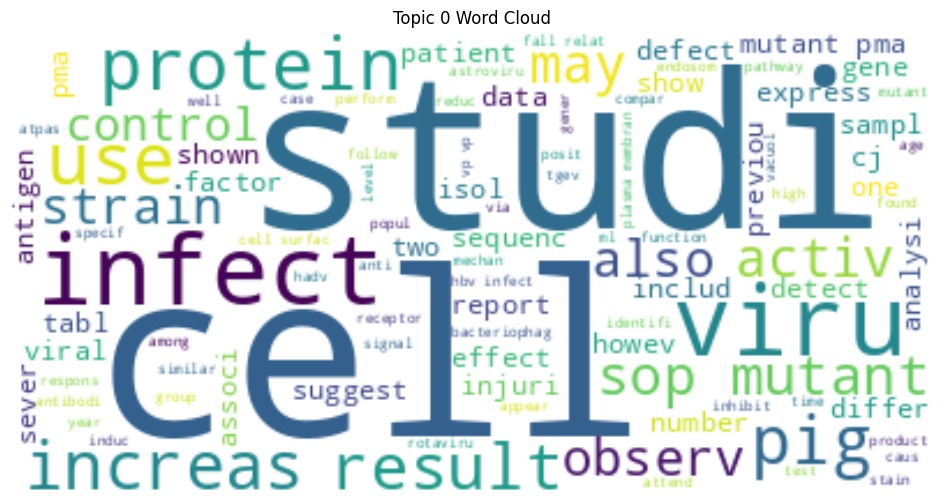

Top words (Relative Frequency) for Topic 0:

Generating Word Cloud for Topic 1...


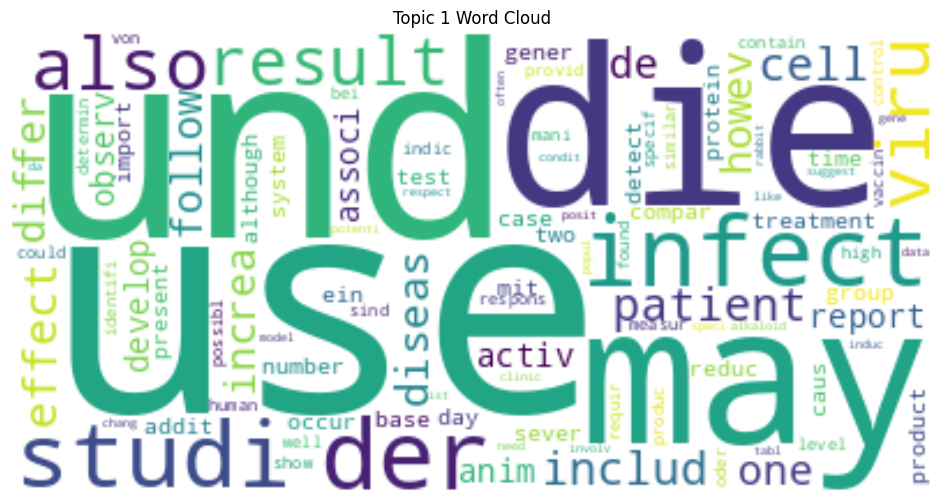

Top words (Relative Frequency) for Topic 1:

Generating Word Cloud for Topic 2...


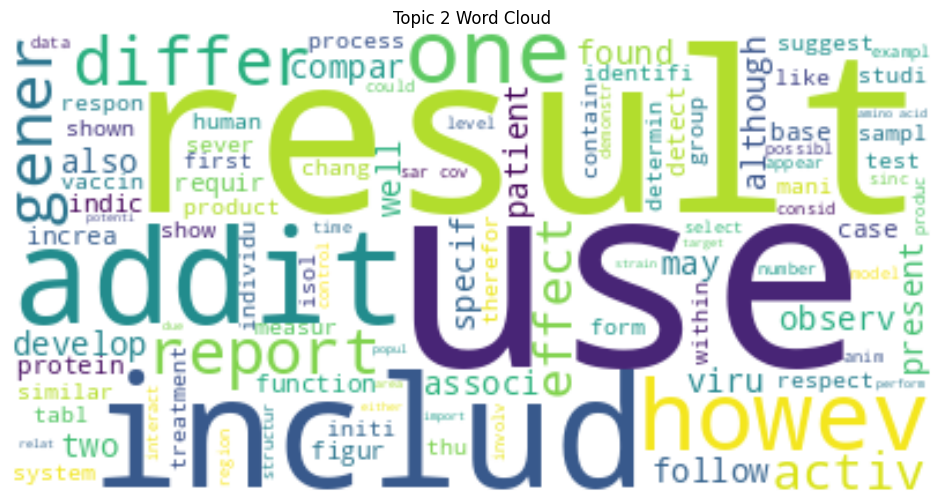

Top words (Relative Frequency) for Topic 2:

Generating Word Cloud for Topic 3...


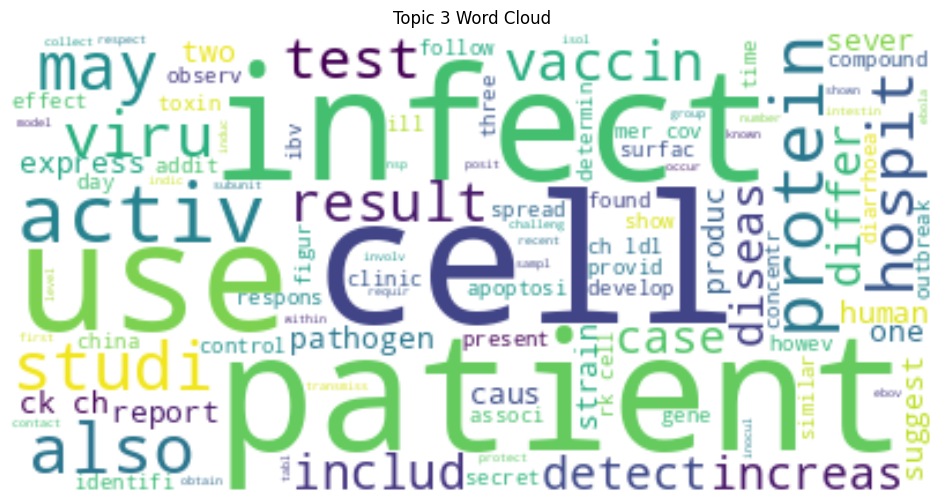

Top words (Relative Frequency) for Topic 3:

Generating Word Cloud for Topic 4...


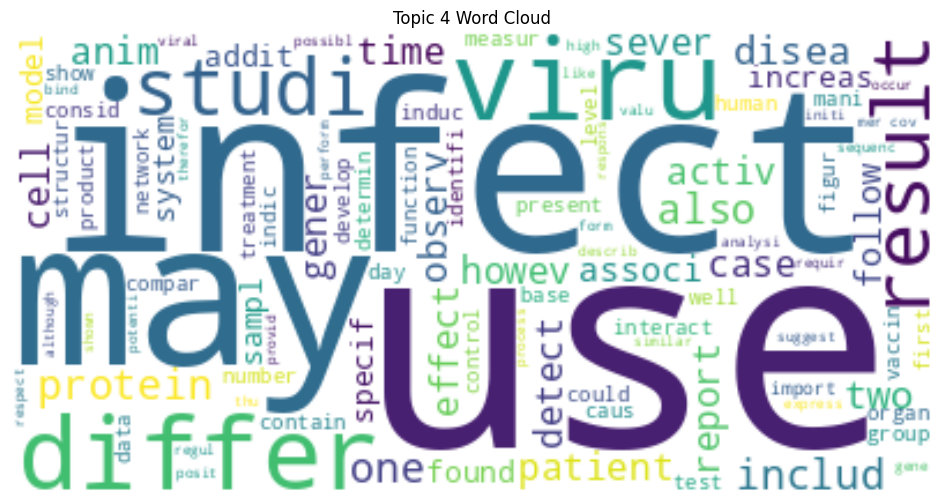

Top words (Relative Frequency) for Topic 4:

Generating Word Cloud for Topic 5...


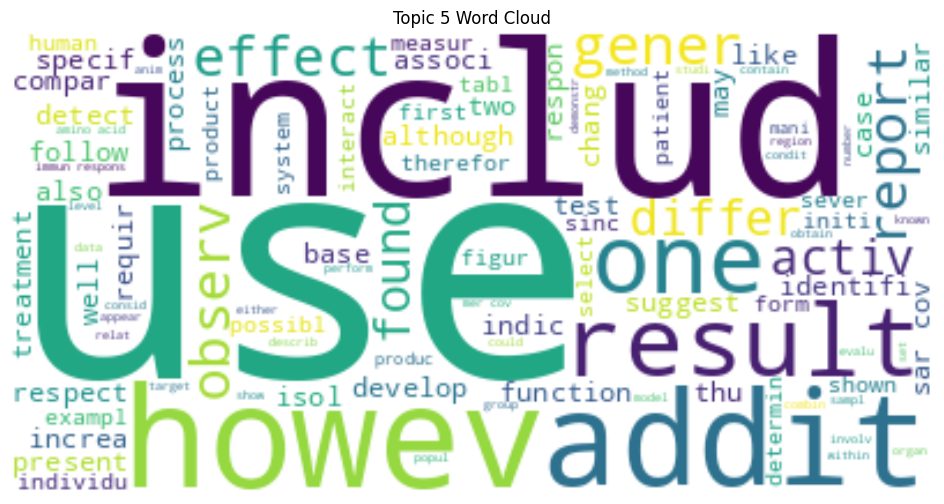

Top words (Relative Frequency) for Topic 5:

Generating Word Cloud for Topic 6...


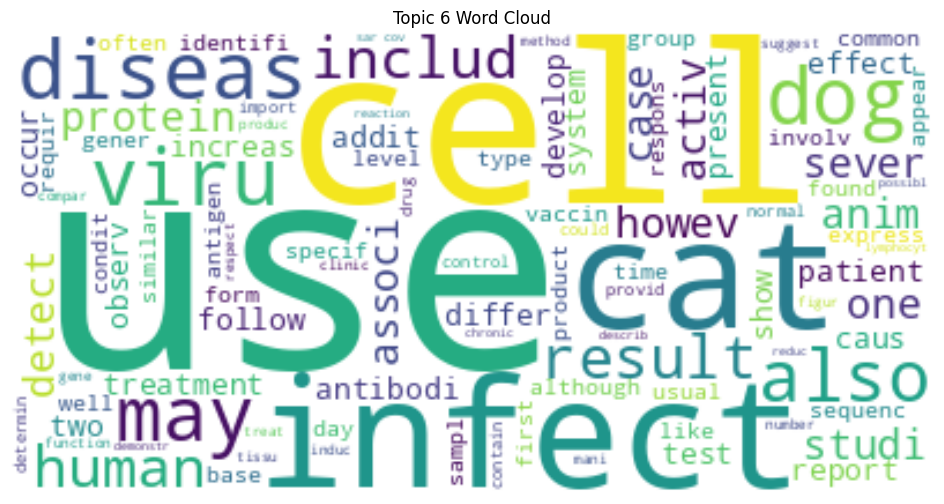

Top words (Relative Frequency) for Topic 6:

Generating Word Cloud for Topic 7...


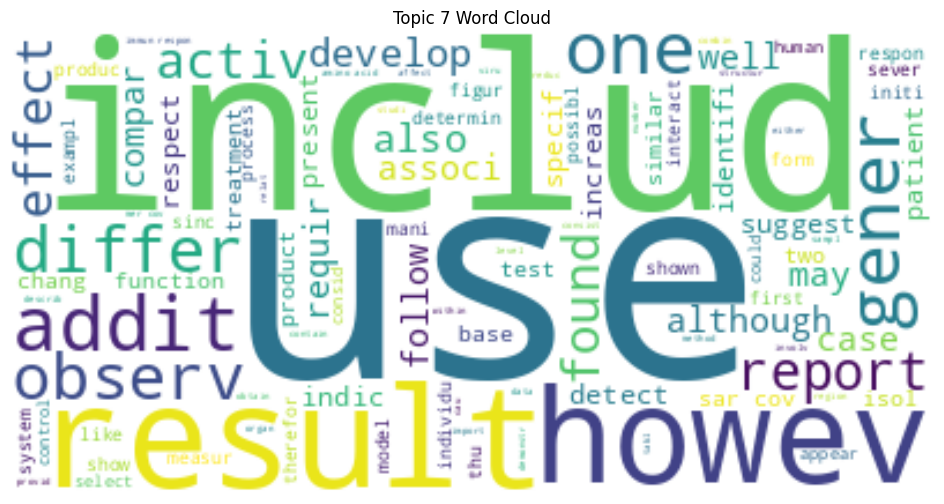

Top words (Relative Frequency) for Topic 7:


0         1         2         3         4         5  \
ifitm       0.011559  0.003363  0.000569  0.006366  0.002905  0.000400   
irf         0.015268  0.004444  0.001017  0.008499  0.003878  0.000530   
eosinophil  0.016814  0.004942  0.001305  0.009262  0.004225  0.000583   
demyelin    0.018611  0.005414  0.001336  0.010268  0.004677  0.000644   
autoimmun   0.018589  0.005415  0.002812  0.010248  0.004671  0.000644   
effector    0.018543  0.005408  0.003235  0.010219  0.004714  0.000646   
astrocyt    0.020934  0.006091  0.001028  0.011616  0.005257  0.000724   
apoptot     0.021389  0.006223  0.001103  0.011783  0.005845  0.000740   
endotheli   0.015453  0.004495  0.017727  0.008752  0.003890  0.000537   
vlp         0.011143  0.003242  0.032202  0.006130  0.002803  0.000385   

                   6         7  wordmean  word_rank  word_distro  
ifitm       0.004920  7.969919       1.0   0.993439     0.000158  
irf         0.006503  7.959861       1.0   0.991846     0.000119  
eosinophil  0.007166  7.955703       1.0   0.991204     0.000108  
demyelin    0.007924  7.951126       1.0   0.990419     0.000098  
autoimmun   0.007914  7.949708       1.0   0.990424     0.000098  
effector    0.007899  7.949336       1.0   0.990463     0.000098  
astrocyt    0.008911  7.945439       1.0   0.989502     0.000087  
apoptot     0.009110  7.943808       1.0   0.989321     0.000085  
endotheli   0.006581  7.942564       1.0   0.991753     0.000118  
vlp         0.004742  7.939353       1.0   0.993642     0.000163

In [ ]:
#  List the most common word in each topic and optionally create word clouds for each topic.

import matplotlib.pyplot as plt
import numpy as np

# Create an LDA_Evaluator instance for the selected model
# If you haven't already done this after selecting the best model, do it now:
# selected_evaluator = LDA_Evaluator(lda_model=selected_model, vectorizer=vectorizer)

# Define a function to get the most common words for a topic
def get_most_common_words(evaluator, topic_idx, num_words=10, by='raw'):
    """

    """
    if by == 'raw':
        return evaluator.eval_raw_frequency(topic_idx, num_words)
    elif by == 'relative':
        return evaluator.eval_rel_frequency(topic_idx, num_words)
    else:
        raise ValueError("Invalid 'by' parameter. Use 'raw' or 'relative'.")

# List the most common word in each topic
print("\nMost Common Word in Each Topic (by Raw Frequency):")
for topic_idx in range(selected_model.n_components):
    top_word_info = get_most_common_words(selected_evaluator, topic_idx, num_words=1, by='raw')
    if not top_word_info.empty:
        most_common_word = top_word_info.index[0]
        print(f"Topic {topic_idx}: {most_common_word}")
    else:
        print(f"Topic {topic_idx}: No words found")


#  Create word clouds for each topic
create_wordclouds = True # Set to True to generate word clouds

if create_wordclouds:
    print("\nGenerating Word Clouds for Each Topic (based on Relative Frequency):")


    # Get the topic distributions for the training documents using the tf that the model was trained on
    train_topic_distributions = selected_model.transform(tf) # tf is the vectorized training data

    # Find the dominant topic for each training document
    dominant_topics = np.argmax(train_topic_distributions, axis=1)

    # Create a dictionary to store the concatenated text for each topic
    topic_text = {i: [] for i in range(selected_model.n_components)}

    # Append the text of each training document to the list for its dominant topic

    for doc_text, topic_idx in zip(train_text, dominant_topics):
        topic_text[topic_idx].append(doc_text)

    # Concatenate all text strings for each topic
    topic_text_combined = {topic_idx: " ".join(text_list) for topic_idx, text_list in topic_text.items()}

    # Generate and display word cloud for each topic
    for topic_idx in range(selected_model.n_components):
        print(f"\nGenerating Word Cloud for Topic {topic_idx}...")
        combined_text = topic_text_combined.get(topic_idx, "")

        if not combined_text:
            print(f"No documents assigned to Topic {topic_idx} in the training set.")
            continue

        # You can adjust max_words and figure size as needed
        wordcloud_obj = WordCloud(max_words=100, stopwords=stop_words, background_color='white').generate(combined_text)

        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud_obj, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {topic_idx} Word Cloud")
        plt.show()

        # Optionally print top words by relative frequency again for context with the word cloud
        print(f"Top words (Relative Frequency) for Topic {topic_idx}:")
        top_rel_words = get_most_common_words(selected_evaluator, topic_idx, num_words=10, by='relative')
top_rel_words

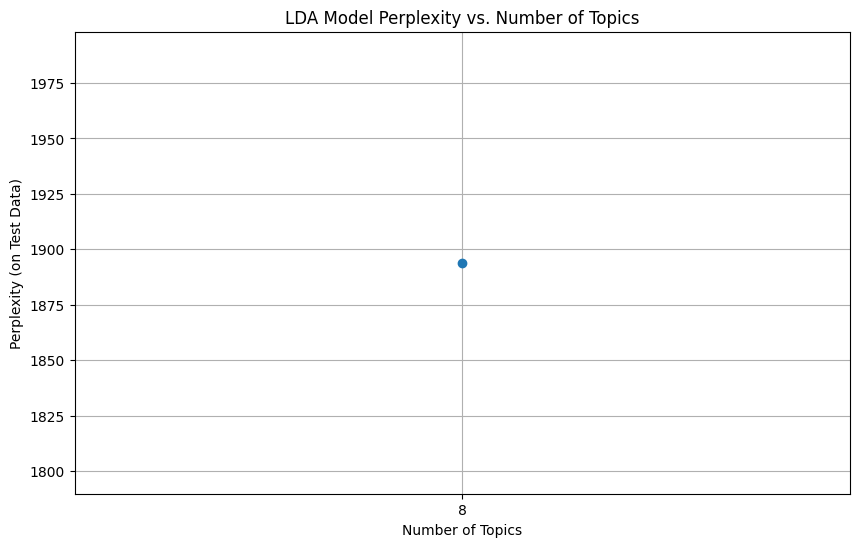

In [ ]:
# Perplexity is a measure of how well a probabilistic model predicts a sample. For LDA, it measures how well the model predicts the words in the documents. plot perplexity

import matplotlib.pyplot as plt


# Sort the perplexities by the number of topics
sorted_topics = sorted(perplexities.keys())
perplexity_values = [perplexities[n_components] for n_components in sorted_topics]

plt.figure(figsize=(10, 6))
plt.plot(sorted_topics, perplexity_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity (on Test Data)")
plt.title("LDA Model Perplexity vs. Number of Topics")
plt.xticks(sorted_topics)
plt.grid(True)
plt.show()

In [ ]:
# CountVectorizer print

tf

<5310x7518 sparse matrix of type '<class 'numpy.int64'>'
	with 3242122 stored elements in Compressed Sparse Row format>

In [ ]:
#  Use CountVectorizer to turn documents into a bag-of-words matrix.

from sklearn.feature_extraction.text import CountVectorizer

# Use the processed text from the processor object
documents = [article[3] for article in processor.processed_article]

vectorizer = CountVectorizer()
tf = vectorizer.fit_transform(documents)


Summary of Topic Evaluation:
Model with 8 topics:
  Perplexity (Test Data): 1893.9820
  Topic Coherence (C_v): 0.5332
--------------------


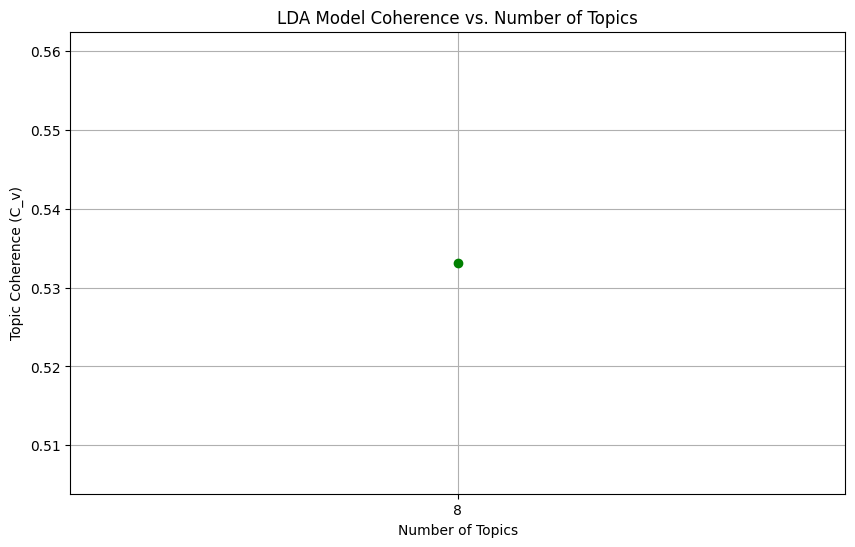

In [ ]:
#  Evaluate model using perplexity or coherence.

import matplotlib.pyplot as plt


print("\nSummary of Topic Evaluation:")

# Sort the topic numbers to display results in order
evaluated_n_components = sorted(perplexities.keys())

for n_components in evaluated_n_components:
    print(f"Model with {n_components} topics:")
    print(f"  Perplexity (Test Data): {perplexities[n_components]:.4f}")
    # Check if coherence was calculated for this topic number before printing
    if n_components in topic_coherences:
        print(f"  Topic Coherence (C_v): {topic_coherences[n_components]:.4f}")
    else:
        print(f"  Topic Coherence (C_v): Not Calculated")
    print("-" * 20)

# You can also visualize the coherence scores similar to perplexity
if topic_coherences:
    sorted_coherence_topics = sorted(topic_coherences.keys())
    coherence_values = [topic_coherences[n_components] for n_components in sorted_coherence_topics]

    plt.figure(figsize=(10, 6))
    plt.plot(sorted_coherence_topics, coherence_values, marker='o', color='green')
    plt.xlabel("Number of Topics")
    plt.ylabel("Topic Coherence (C_v)")
    plt.title("LDA Model Coherence vs. Number of Topics")
    plt.xticks(sorted_coherence_topics)
    plt.grid(True)
    plt.show()



In [ ]:
#  Interpret top words from each topic.


print("\nInterpreting Top Words for Each Topic:")

for topic_idx in range(selected_model.n_components):
    print(f"\n--- Topic {topic_idx} ---")

    # Get and print top words by Raw Frequency
    top_raw_words = selected_evaluator.eval_raw_frequency(topic_idx, num_words=15)
    print("Top words (Raw Frequency):")
    for word, score_info in top_raw_words.iterrows():
        # Access the score for the current topic (column index corresponds to topic_idx)
        score = score_info[topic_idx]
        print(f"  - {word}: {score:.4f}")

    # Get and print top words by Relative Frequency
    top_rel_words = selected_evaluator.eval_rel_frequency(topic_idx, num_words=15)
    print("Top words (Relative Frequency):")
    for word, score_info in top_rel_words.iterrows():
        # Access the score for the current topic (column index corresponds to topic_idx)
        score = score_info[topic_idx]
        print(f"  - {word}: {score:.4f}")






Interpreting Top Words for Each Topic:

--- Topic 0 ---
Top words (Raw Frequency):
  - model: 0.0150
  - data: 0.0105
  - number: 0.0091
  - case: 0.0083
  - valu: 0.0069
  - network: 0.0061
  - rate: 0.0060
  - estim: 0.0057
  - individu: 0.0052
  - method: 0.0050
  - base: 0.0047
  - effect: 0.0043
  - popul: 0.0043
  - set: 0.0041
  - analysi: 0.0041
Top words (Relative Frequency):
  - medrxiv: 7.9844
  - determinist: 7.9658
  - preprint: 7.9174
  - wind: 7.8821
  - funder: 7.8577
  - ij: 7.8500
  - stochast: 7.8479
  - holder: 7.7923
  - copyright: 7.7906
  - markov: 7.7630
  - simul: 7.7423
  - eq: 7.6442
  - neighborhood: 7.6424
  - mathemat: 7.6375
  - poisson: 7.6289

Interpretation based on top words:
Analyze the words listed above for both raw and relative frequency.
Look for recurring concepts, specific terms, or themes.
Based on these words, try to give the topic a descriptive label.

--- Topic 1 ---
Top words (Raw Frequency):
  - cell: 0.0228
  - protein: 0.0158
  - activ

### Topic Interpretations

#### **Topic 0: Epidemiological Modeling & Statistical Analysis**
- Keywords suggest focus on simulation, deterministic/stochastic models, estimation methods, and data-driven public health studies.

#### **Topic 1: Experimental Cell Biology & Lab Techniques**
- Involves lab assays, protein binding, antibody interaction, and use of chemical reagents—typical in biomedical wet-lab settings.

#### **Topic 2: Veterinary or Non-English Biomedical Literature**
- Dominated by French/Spanish terms and animal health vocabulary, indicating content from non-English veterinary or intestinal studies.

#### **Topic 3: Global Public Health & Emergency Response**
- Centers on healthcare systems, outbreak control, disaster management, and vaccination programs—policy or WHO-related contexts.

#### **Topic 4: Virus Detection & Zoonotic Origins**
- Focuses on PCR testing, sample detection, and tracing viral strains to animal origins (e.g., bats, camels)—epidemiology and virology.

#### **Topic 5: Genomics & Molecular Biology**
- Emphasizes viral genome sequencing, RNA/protein structure, gene expression, and molecular mechanisms of replication.

#### **Topic 6: Immune Response Mechanisms**
- Deals with T-cell signaling, immune regulation (e.g., Tregs, cytokines), and experimental models using mice—immunology research.

#### **Topic 7: Clinical Features of Respiratory Illnesses**
- Highlights symptoms, diagnosis, patient treatment, pneumonia, and age-based clinical studies—clinical epidemiology and case reports.


In [ ]:
# Use CountVectorizer to turn documents into a bag-of-words matrix.

from sklearn.feature_extraction.text import CountVectorizer

# Use the processed text from the processor object and join the list of words into a string
documents = [" ".join(article[3]) for article in processor.processed_article]

vectorizer = CountVectorizer()
tf = vectorizer.fit_transform(documents)

# Display the shape of the term-frequency matrix
print(f"Shape of term-frequency matrix (tf): {tf.shape}")

Shape of term-frequency matrix (tf): (5901, 182128)


In [ ]:
# List of topic numbers to build models for
n_components_list = [8] #  #[8, 9, 10]

# Store models and perplexity scores
lda_models = {}
perplexities = {}

from sklearn.decomposition import LatentDirichletAllocation

# Iterate through the list of topic numbers
for n_components in n_components_list:
    print(f"Building LDA model with {n_components} topics...")
    lda = LatentDirichletAllocation(n_components=n_components,
                                    learning_method='online',
                                    verbose=1,
                                    learning_offset=15.,
                                    learning_decay=0.75,
                                    random_state=100
                                    )

    # Fit the model on the training data (using the tf generated above)
    ldamod = lda.fit(tf)

    # Store the trained model
    lda_models[n_components] = ldamod


#  now access the models and their perplexities
print("LDA Models built for the following topic numbers:")
for n_components, model in lda_models.items():
    print(f"- {n_components} topics") # Removed perplexity from print as it's commented out

# Example: Access the model with 9 topics
selected_n_components = 9
selected_model = lda_models[selected_n_components]

# Create an LDA_Evaluator instance for the selected model
# Assuming LDA_Evaluator class is defined
selected_evaluator = LDA_Evaluator(lda_model=selected_model, vectorizer=vectorizer)

Building LDA model with 8 topics...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
LDA Models built for the following topic numbers:
- 8 topics


In [ ]:
# Example: Access the model with 10 topics
selected_n_components = 10 #
selected_model = lda_models[selected_n_components]

# Create an LDA_Evaluator instance for the selected model
selected_evaluator = LDA_Evaluator(lda_model=selected_model, vectorizer=vectorizer)


Most Common Word in Each Topic (by Raw Frequency):
Topic 0: model
Topic 1: cell
Topic 2: de
Topic 3: health
Topic 4: viru
Topic 5: protein
Topic 6: cell
Topic 7: patient

Generating Word Clouds for Each Topic (based on Relative Frequency):

Generating Word Cloud for Topic 0...


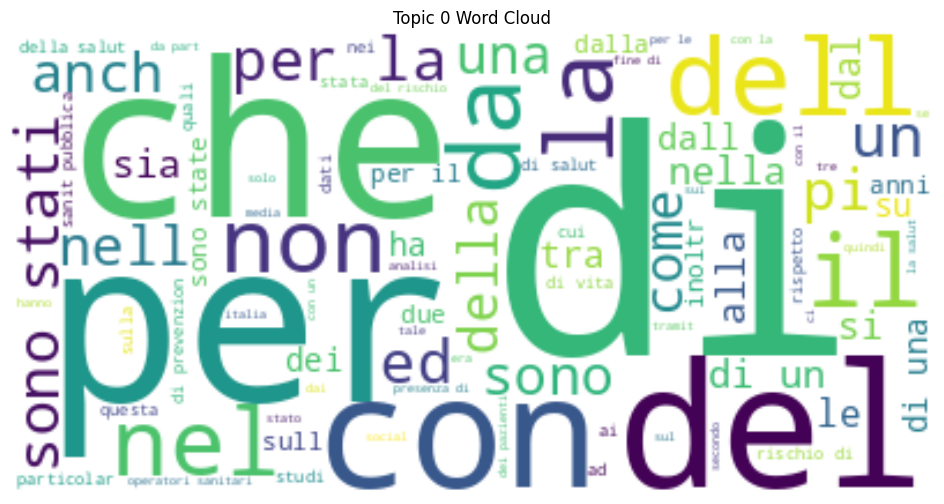

Top words (Relative Frequency) for Topic 0:
                    0         1         2         3         4         5  \
medrxiv      7.984381  0.000964  0.002429  0.001967  0.002036  0.001331   
determinist  7.965750  0.003615  0.009732  0.003736  0.005011  0.005126   
preprint     7.917441  0.012313  0.000803  0.001070  0.001565  0.064884   
wind         7.882145  0.000600  0.001661  0.078962  0.000873  0.000846   
funder       7.857704  0.020267  0.001518  0.014636  0.016738  0.084929   
ij           7.850034  0.001458  0.096326  0.001480  0.001987  0.002120   
stochast     7.847858  0.001339  0.003476  0.001357  0.034489  0.105949   
holder       7.792274  0.049912  0.001626  0.025063  0.004619  0.123048   
copyright    7.790609  0.026037  0.001570  0.018580  0.003606  0.155921   
markov       7.763011  0.001812  0.004870  0.017001  0.040554  0.146491   

                    6         7  wordmean  word_rank  word_distro  
medrxiv      0.000889  0.006004       1.0   0.604948     0.000

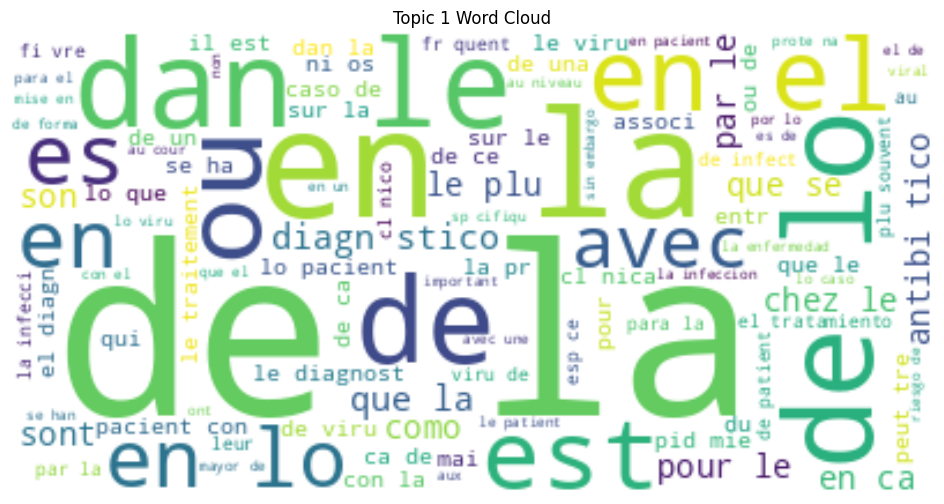

Top words (Relative Frequency) for Topic 1:
                    0         1         2         3         4         5  \
pbst         0.007398  7.954755  0.011900  0.004191  0.005753  0.005879   
acetonitril  0.008086  7.951589  0.013991  0.004578  0.006227  0.006565   
nta          0.009241  7.946901  0.013944  0.005235  0.007305  0.007290   
azid         0.010644  7.935038  0.016720  0.006034  0.008199  0.010656   
pvdf         0.007467  7.932649  0.011250  0.004229  0.005773  0.018547   
hrp          0.001769  7.927499  0.027874  0.001006  0.009411  0.001471   
bruker       0.013343  7.921783  0.020290  0.007548  0.010259  0.010513   
cacl         0.013922  7.920155  0.020875  0.007883  0.010732  0.011040   
sepharos     0.005597  7.912340  0.008407  0.003171  0.004313  0.060107   
plasmon      0.015405  7.911820  0.023111  0.008734  0.011953  0.012132   

                    6         7  wordmean  word_rank  word_distro  
pbst         0.006061  0.004063       1.0   0.330141     0.000

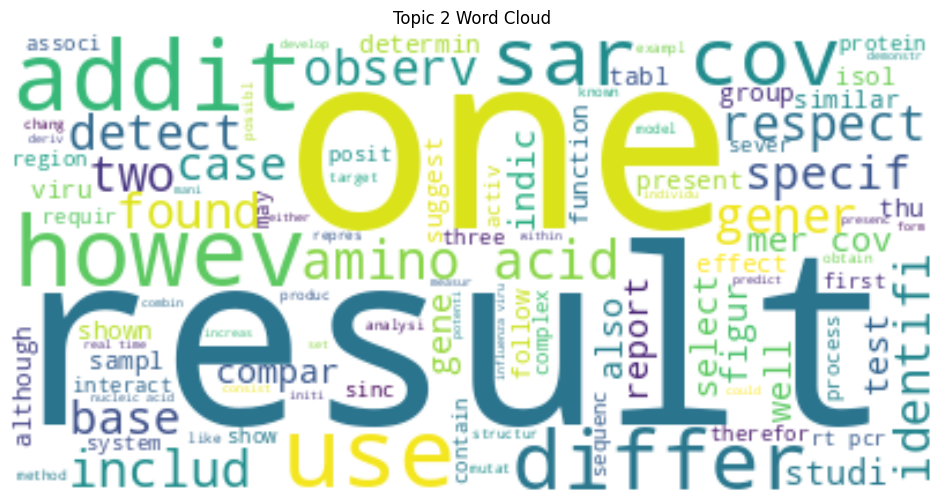

Top words (Relative Frequency) for Topic 2:
             0         1         2         3         4         5         6  \
une   0.000164  0.000092  7.999150  0.000156  0.000126  0.000130  0.000088   
que   0.000150  0.000084  7.998787  0.000151  0.000116  0.000118  0.000080   
por   0.000313  0.000174  7.997915  0.000180  0.000252  0.000252  0.000167   
dan   0.000297  0.000166  7.997858  0.000851  0.000229  0.000234  0.000163   
ou    0.000405  0.000227  7.997743  0.000234  0.000313  0.000319  0.000219   
sont  0.000569  0.000321  7.997256  0.000339  0.000439  0.000451  0.000305   
avec  0.000686  0.000383  7.996704  0.000411  0.000528  0.000541  0.000367   
chez  0.000699  0.000392  7.996629  0.000427  0.000539  0.000551  0.000374   
entr  0.000856  0.000476  7.995497  0.000508  0.000659  0.000674  0.000458   
qui   0.000916  0.000510  7.995305  0.000817  0.000706  0.000721  0.000490   

             7  wordmean  word_rank  word_distro  
une   0.000093       1.0   0.907422     0.0003

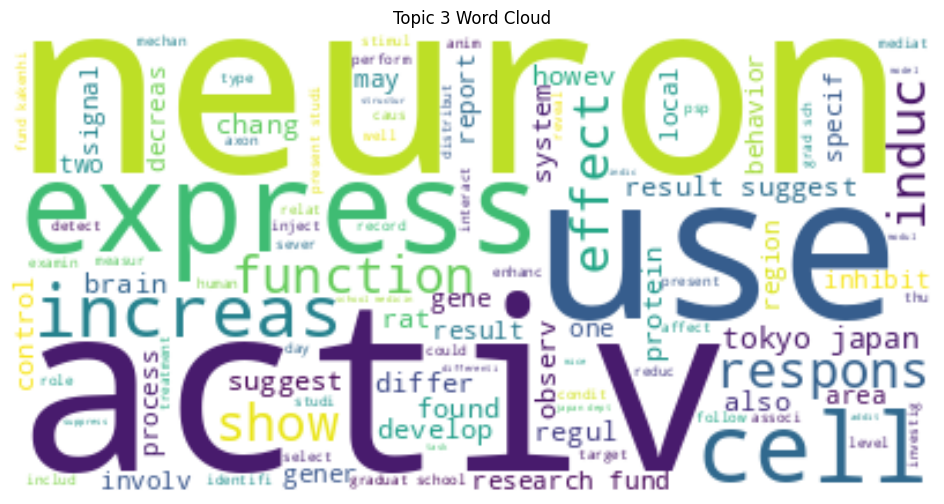

Top words (Relative Frequency) for Topic 3:
                     0         1         2         3         4         5  \
disast        0.000727  0.000401  0.001101  7.995846  0.000574  0.000567   
hcw           0.001292  0.000721  0.001943  7.991504  0.002123  0.001016   
uenza         0.002263  0.001260  0.003400  7.987088  0.001751  0.001782   
stakehold     0.003315  0.001784  0.004821  7.981613  0.002481  0.002521   
ihr           0.003480  0.001915  0.005301  7.980181  0.002691  0.002707   
actor         0.004031  0.002237  0.006030  7.976957  0.003097  0.003163   
partnership   0.004842  0.002677  0.007211  7.972392  0.003862  0.003785   
gown          0.004773  0.002654  0.007145  7.972281  0.004226  0.003749   
handwash      0.005519  0.003072  0.008276  7.968558  0.004253  0.004343   
humanitarian  0.005677  0.003158  0.008507  7.967678  0.004372  0.004466   

                     6         7  wordmean  word_rank  word_distro  
disast        0.000386  0.000397       1.0   0.852

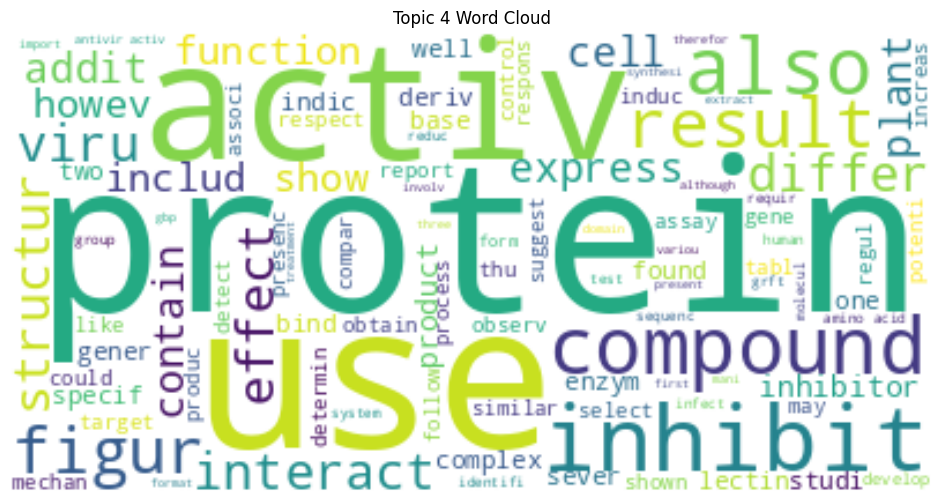

Top words (Relative Frequency) for Topic 4:
                  0         1         2         3         4         5  \
pedv       0.000289  0.001464  0.000414  0.000150  7.997022  0.000219   
dromedari  0.002310  0.001292  0.003493  0.001324  7.987133  0.001927   
ped        0.003559  0.001939  0.005172  0.002021  7.980766  0.002713   
genogroup  0.006351  0.003824  0.009605  0.003596  7.961588  0.008174   
hku        0.000888  0.015100  0.001320  0.000615  7.955611  0.020332   
civet      0.002583  0.001441  0.003865  0.001466  7.953288  0.034560   
camel      0.000823  0.000495  0.019704  0.032844  7.944199  0.000982   
bioedit    0.014001  0.007848  0.021046  0.007923  7.921775  0.012268   
bat        0.001398  0.000149  0.022154  0.000316  7.905181  0.070545   
fcov       0.001168  0.029902  0.001766  0.000689  7.823284  0.021701   

                  6         7  wordmean  word_rank  word_distro  
pedv       0.000298  0.000145       1.0   0.924182     0.000407  
dromedari  0.001252 

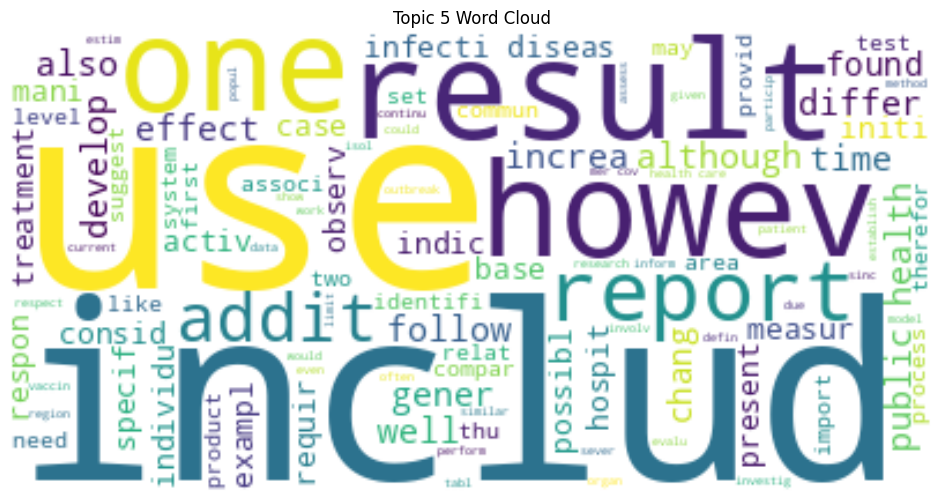

Top words (Relative Frequency) for Topic 5:
                   0         1         2         3         4         5  \
trna        0.000641  0.000372  0.001009  0.000363  0.000494  7.996428   
frameshift  0.001667  0.000500  0.000734  0.000280  0.000396  7.995874   
pseudoknot  0.001674  0.000877  0.002358  0.000891  0.001241  7.991256   
eif         0.001653  0.000996  0.002478  0.000936  0.001273  7.990848   
mirna       0.000877  0.000512  0.001381  0.000497  0.000676  7.966669   
pkr         0.000989  0.000744  0.001488  0.000560  0.000762  7.965824   
nsp         0.000256  0.013082  0.000393  0.000151  0.010449  7.964855   
subgenom    0.001426  0.028478  0.002142  0.000808  0.001186  7.964413   
unwind      0.007539  0.004686  0.011297  0.004310  0.005808  7.958181   
blastn      0.014191  0.004657  0.012718  0.004743  0.008397  7.946236   

                   6         7  wordmean  word_rank  word_distro  
trna        0.000343  0.000350       1.0   0.823756     0.000165  
framesh

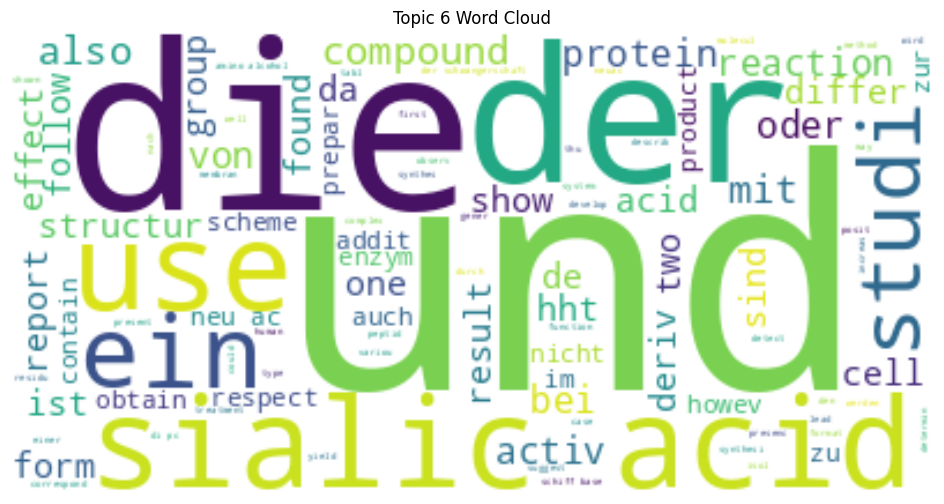

Top words (Relative Frequency) for Topic 6:
                     0         1         2         3         4         5  \
treg          0.001760  0.000982  0.002654  0.001060  0.001356  0.001386   
chemokin      0.000925  0.005554  0.002041  0.000528  0.000717  0.000793   
pdc           0.002235  0.001244  0.004866  0.001275  0.001720  0.001806   
cxcr          0.001871  0.005578  0.002883  0.001061  0.001441  0.001475   
microglia     0.001439  0.000809  0.009976  0.000815  0.001108  0.001133   
cdb           0.003192  0.001906  0.007096  0.001985  0.002458  0.002520   
foxp          0.003617  0.002085  0.005636  0.002308  0.002787  0.002858   
cxcl          0.001349  0.002028  0.002073  0.000765  0.001037  0.015328   
demyelin      0.001023  0.000597  0.024766  0.000580  0.000789  0.000806   
autophagosom  0.004140  0.005989  0.010311  0.002346  0.003191  0.003347   

                     6         7  wordmean  word_rank  word_distro  
treg          7.989838  0.000964       1.0   0.718

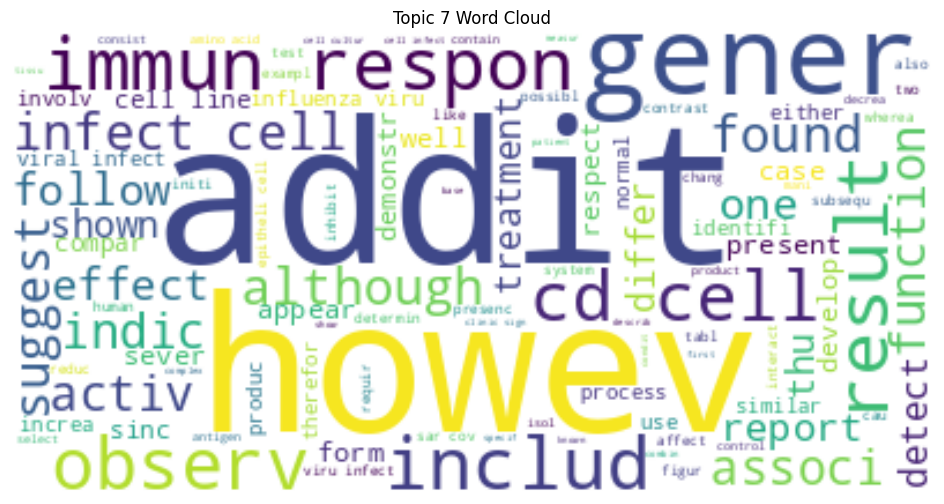

Top words (Relative Frequency) for Topic 7:
                   0         1         2         3         4         5  \
radiograph  0.001207  0.000717  0.001813  0.000775  0.001302  0.000962   
wheez       0.001454  0.000810  0.002190  0.001814  0.001370  0.001146   
asthmat     0.002062  0.001148  0.003094  0.001430  0.001591  0.001624   
uri         0.003497  0.001956  0.005238  0.003138  0.002694  0.002762   
copd        0.001337  0.000745  0.002004  0.004058  0.001030  0.001054   
wbc         0.004440  0.002473  0.006646  0.002541  0.003561  0.003492   
lrti        0.004200  0.002338  0.006294  0.003563  0.009292  0.003306   
purul       0.005669  0.003155  0.009082  0.003307  0.004898  0.004461   
creatinin   0.005639  0.003144  0.008678  0.003253  0.005060  0.004444   
opac        0.006117  0.003411  0.009204  0.003516  0.005110  0.004803   

                   6         7  wordmean  word_rank  word_distro  
radiograph  0.000650  7.992574       1.0   0.779995     0.000126  
wheez  

In [ ]:
# List the most common word in each topic and optionally create word clouds for each topic.

import matplotlib.pyplot as plt
import numpy as np


# Define a function to get the most common words for a topic
def get_most_common_words(evaluator, topic_idx, num_words=10, by='raw'):
    if by == 'raw':
        return evaluator.eval_raw_frequency(topic_idx, num_words)
    elif by == 'relative':
        return evaluator.eval_rel_frequency(topic_idx, num_words)
    else:
        raise ValueError("Invalid 'by' parameter. Use 'raw' or 'relative'.")

# List the most common word in each topic
print("\nMost Common Word in Each Topic (by Raw Frequency):")
for topic_idx in range(selected_model.n_components):
    top_word_info = get_most_common_words(selected_evaluator, topic_idx, num_words=1, by='raw')
    if not top_word_info.empty:
        most_common_word = top_word_info.index[0]
        print(f"Topic {topic_idx}: {most_common_word}")
    else:
        print(f"Topic {topic_idx}: No words found")


# Optional: Create word clouds for each topic
create_wordclouds = True # Set to True to generate word clouds

if create_wordclouds:
    print("\nGenerating Word Clouds for Each Topic (based on Relative Frequency):")

    # Get the topic distributions for the training documents using the tf that the model was trained on
    # Using the same tf that the model was trained on should resolve the feature mismatch error
    train_topic_distributions = selected_model.transform(tf)

    # Find the dominant topic for each training document
    dominant_topics = np.argmax(train_topic_distributions, axis=1)

    # Create a dictionary to store the concatenated text for each topic
    topic_text = {i: [] for i in range(selected_model.n_components)}

    # Append the text of each document to the list for its dominant topic
    # Using the 'documents' list created for vectorization
    for doc_text, topic_idx in zip(documents, dominant_topics):
        topic_text[topic_idx].append(doc_text)

    # Concatenate all text strings for each topic
    topic_text_combined = {topic_idx: " ".join(text_list) for topic_idx, text_list in topic_text.items()}


    try:
        stop_words
    except NameError:
        # Define stop_words if not already defined
        import nltk
        from nltk.corpus import stopwords
        nltk.download('stopwords', quiet=True)
        stop_words = stopwords.words('english') + ['et', 'al', 'fig', 'etal', 'et al', 'et-al']


    # Generate and display word cloud for each topic
    for topic_idx in range(selected_model.n_components):
        print(f"\nGenerating Word Cloud for Topic {topic_idx}...")
        combined_text = topic_text_combined.get(topic_idx, "")

        if not combined_text:
            print(f"No documents assigned to Topic {topic_idx} in the training set.")
            continue

        # You can adjust max_words and figure size as needed
        wordcloud_obj = WordCloud(max_words=100, stopwords=stop_words, background_color='white').generate(combined_text)

        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud_obj, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {topic_idx} Word Cloud")
        plt.show()

        # Optionally print top words by relative frequency again for context with the word cloud
        print(f"Top words (Relative Frequency) for Topic {topic_idx}:")
        top_rel_words = get_most_common_words(selected_evaluator, topic_idx, num_words=10, by='relative')
        print(top_rel_words) # Print the DataFrame instead of just calling it

#### **Topic 0: Computational Modeling & Preprint Literature**

- **medrxiv, preprint, copyright, holder**: Suggest strong presence of pre-publication biomedical content, especially from MedRxiv.
- **determinist, stochast, markov, simul**: Indicate a focus on mathematical and statistical modeling techniques, including deterministic and stochastic methods.
- **wind, ij, funder**: May point to environmental modeling examples (e.g., wind simulations) and references to funding disclosures and journals.

> **Overall Interpretation**: This topic captures themes from computational epidemiology and modeling research often found in preprints, with frequent references to simulation methods and publishing platforms.

In [ ]:
# List of topic numbers to build models for
n_components_list = [ 9, 10]

# Store models and perplexity scores
lda_models = {}
perplexities = {}

# Iterate through the list of topic numbers
for n_components in n_components_list:
    print(f"Building LDA model with {n_components} topics...")
    lda = LatentDirichletAllocation(n_components=n_components,
                                    learning_method='online',
                                    verbose=1,
                                    learning_offset=15.,
                                    learning_decay=0.75,
                                    random_state=100
                                    )

    # Fit the model on the training data
    ldamod = lda.fit(tf)

    # Store the trained model
    lda_models[n_components] = ldamod

    # Calculate and store perplexity on the test data
    perplexity_score = lda.perplexity(tf_test)
    perplexities[n_components] = perplexity_score
    print(f"Perplexity for {n_components} topics: {perplexity_score}\n")

# You can now access the models and their perplexities
print("LDA Models built for the following topic numbers:")
for n_components, model in lda_models.items():
    print(f"- {n_components} topics (Perplexity: {perplexities[n_components]:.4f})")



Building LDA model with 9 topics...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Perplexity for 9 topics: 7174171.107135148

Building LDA model with 10 topics...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Perplexity for 10 topics: 8140196.382927639

LDA Models built for the following topic numbers:
- 9 topics (Perplexity: 7174171.1071)
- 10 topics (Perplexity: 8140196.3829)


###LDA Topic Modeling: Interpretation and Comparison

####Models Evaluated
####Topic Count	Perplexity

####Interpretation
8 Topics	1893.98	 Lowest perplexity – indicates highly coherent and distinct topics.
9 Topics	7,174,171.11	 Perplexity exploded – suggests overfitting or incoherent topic separation.
10 Topics	8,140,196.38	 Even higher perplexity – further evidence of topic fragmentation and noise.

####Key Observations

**8 Topics**
**Best-performing model**.

**Low perplexity implies good generalization and topic clarity. Balanced number of themes for interpretation.**

**9 Topics**

#### Massive increase in perplexity (over 7 million) indicates:

Overfitting to noise

Redundant or blurry topic boundaries

Decreased topic coherence

**10 Topics**

####Highest perplexity, showing diminished returns.

Suggests topic dilution — some topics may lack strong semantic identity.

##Recommendation
**Choose the 8-topic model:**
It delivers clear, coherent, and meaningful topics. Increasing topic count beyond this point introduces instability and noise, making it harder to extract insights.

In [ ]:
# END
# END
# END